In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import polars as pl
pl.enable_string_cache(True)

warnings.filterwarnings('ignore')

from feature_engine.encoding import OrdinalEncoder
from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures

from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor
import optuna

seed=42

In [2]:
top_TD_GH_by_district = np.array(
    pl.scan_parquet("../datasets/19_model/train.zstd")
    .groupby(['DISTRICT', 'GEOHASH'])
    .agg(pl.col(['NUMBER_OF_VEHICLES']).mean())
    .sort(['DISTRICT', 'NUMBER_OF_VEHICLES'], descending=True)
    .with_columns(pl.col('NUMBER_OF_VEHICLES').rank('dense', descending=True).over('DISTRICT').alias('TD_row'))
    .filter(pl.col('TD_row').le(1))
    .select('GEOHASH')
    .collect(streaming=True)\
        ['GEOHASH']
    .to_list()
    # .to_pandas()
    # .to_excel("datasets/18_Viz/top_10_td_gh_district.xlsx", index=False)
)

len(top_TD_GH_by_district)

37

In [3]:
# Train set
X = (
    pl.read_parquet("../datasets/19_model/train.zstd")
    .filter(pl.col('GEOHASH').is_in(top_TD_GH_by_district))
    .with_columns(pl.col(['GEOHASH', 'DISTRICT'])
                  .cast(pl.Utf8).cast(pl.Categorical))
    .drop('NUMBER_OF_VEHICLES')
    .to_pandas()
    .set_index('DATE_TIME')
)

y = (
    pl.read_parquet("../datasets/19_model/train.zstd")
    .filter(pl.col('GEOHASH').is_in(top_TD_GH_by_district))
    .select(['DATE_TIME', 'NUMBER_OF_VEHICLES'])
    .to_pandas()
    .set_index('DATE_TIME')
)

X.head()

,GEOHASH,DISTRICT,LOCATION_TYPE,CITIZEN_RETURN,CITIZEN_ARRIVAL,TOURIST_ARRIVAL,HOLIDAY_NAME,HOLIDAY_TYPE,SCHOOL_HOLIDAY_TYPE,HIGHWAY_TRNSPRT_PSNGRS,...,HUMIDITY,PRCP,WINDSPEED,WTHR_CAT,TD_LAG1,TD_LAG24,TD_LAG168,PRCP_LAG1,PRCP_LAG2,PRCP_LAG3
DATE_TIME,,,,,,,,,,,,,,,,,,,,,
2020-01-01,sxk9cb,Sultangazi,junction,627933,692729,1017034,New Year's Day,National holiday,Christmas holidays,15430,...,87,0.0,16.6,normal,231,231,231,0.0,0.0,0.0
2020-01-01,sxkc0s,Sancaktepe,avenue,627933,692729,1017034,New Year's Day,National holiday,Christmas holidays,15430,...,85,0.0,9.5,normal,144,144,144,0.0,0.0,0.0
2020-01-01,sxk9fc,Eyüpsultan,highway,627933,692729,1017034,New Year's Day,National holiday,Christmas holidays,15430,...,87,0.0,16.6,normal,256,256,256,0.0,0.0,0.0
2020-01-01,sxkc24,Çekmeköy,road,627933,692729,1017034,New Year's Day,National holiday,Christmas holidays,15430,...,85,0.0,9.5,normal,102,102,102,0.0,0.0,0.0
2020-01-01,sxk99n,Gaziosmanpaşa,highway,627933,692729,1017034,New Year's Day,National holiday,Christmas holidays,15430,...,84,0.0,22.9,normal,205,205,205,0.0,0.0,0.0


In [4]:
y.head()

,NUMBER_OF_VEHICLES
DATE_TIME,
2020-01-01,231
2020-01-01,144
2020-01-01,256
2020-01-01,102
2020-01-01,205


In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 755688 entries, 2020-01-01 00:00:00 to 2022-04-30 23:00:00
Data columns (total 35 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   GEOHASH                     755688 non-null  category
 1   DISTRICT                    755688 non-null  category
 2   LOCATION_TYPE               755688 non-null  category
 3   CITIZEN_RETURN              755688 non-null  uint32  
 4   CITIZEN_ARRIVAL             755688 non-null  uint32  
 5   TOURIST_ARRIVAL             755688 non-null  uint32  
 6   HOLIDAY_NAME                755688 non-null  category
 7   HOLIDAY_TYPE                755688 non-null  category
 8   SCHOOL_HOLIDAY_TYPE         755688 non-null  category
 9   HIGHWAY_TRNSPRT_PSNGRS      755688 non-null  uint32  
 10  SEA_TRNSPRT_PSNGRS          755688 non-null  uint32  
 11  RAIL_TRNSPRT_PSNGRS         755688 non-null  uint32  
 12  IS_COVID_RESTRICTION    

In [6]:
X.isnull().sum()

GEOHASH                       0
DISTRICT                      0
LOCATION_TYPE                 0
CITIZEN_RETURN                0
CITIZEN_ARRIVAL               0
TOURIST_ARRIVAL               0
HOLIDAY_NAME                  0
HOLIDAY_TYPE                  0
SCHOOL_HOLIDAY_TYPE           0
HIGHWAY_TRNSPRT_PSNGRS        0
SEA_TRNSPRT_PSNGRS            0
RAIL_TRNSPRT_PSNGRS           0
IS_COVID_RESTRICTION          0
FOOTBALL_STADIUM_STATUS       0
NEARBY_LANDMARKS_CNT          0
NEARBY_PARKING_CAPACITY       0
NEARBY_TAXI_STND_CNT          0
NEARBY_MINIBUS_STOPS_CNT      0
NEARBY_FERRIES_CNT            0
NEARBY_METRO_STNS_CNT         0
NEARBY_BUS_STOP_CNT           0
NEARBY_FUEL_STNS_CNT          0
NEARBY_ISBIKE_STANDS_CNT      0
NEARBY_BIKE_MM_PARKING_CNT    0
TEMP                          0
HUMIDITY                      0
PRCP                          0
WINDSPEED                     0
WTHR_CAT                      0
TD_LAG1                       0
TD_LAG24                      0
TD_LAG16

In [7]:
cat_cols = [col for col in X.columns if X[col].dtype=='category']
time_cols = ["month", "day_of_month", "hour", "day_of_week"] #excluding year

print('String columns:', cat_cols)
print('Time columns:', time_cols)

# Extract date time features
dt_feats=DatetimeFeatures(variables='index', features_to_extract = ["year", "month", "day_of_month", "hour", "day_of_week"])

# Encode categorical columns with numbers.
ord_encoder=OrdinalEncoder(encoding_method='arbitrary', variables=cat_cols)

# Convert time features such as day, month, hour and day of week to cyclical features to maintain cyclicity.
cf_encoder=CyclicalFeatures(variables=time_cols, drop_original=True)


#Creating encoder pipeline
encoders = make_pipeline(
    (dt_feats), # Extract date time features
    (ord_encoder), # Ordinal Encoder
    (cf_encoder), # Cyclical Feature
)

String columns: ['GEOHASH', 'DISTRICT', 'LOCATION_TYPE', 'HOLIDAY_NAME', 'HOLIDAY_TYPE', 'SCHOOL_HOLIDAY_TYPE', 'WTHR_CAT']
Time columns: ['month', 'day_of_month', 'hour', 'day_of_week']


In [8]:
# https://hub.packtpub.com/cross-validation-strategies-for-time-series-forecasting-tutorial/
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.9 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

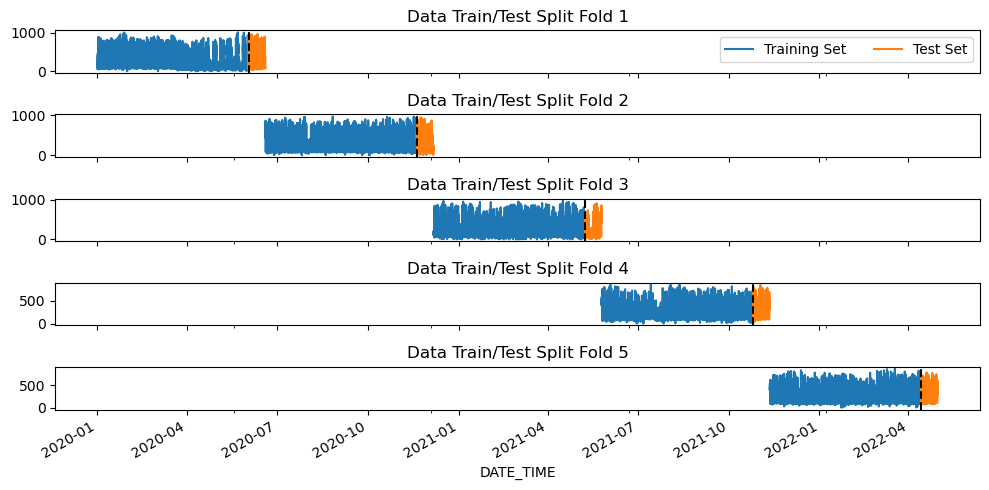

In [9]:
selected_gh=X['GEOHASH'].unique()[:2]

sample = (
    pd.concat([X, y], axis=1)
    .query("GEOHASH in @selected_gh")
)

n_splits=5

btscv = BlockingTimeSeriesSplit(n_splits=n_splits)

fig, axs = plt.subplots(n_splits, 1, figsize=(10, n_splits), sharex=True, tight_layout=True)

fold = 0
for train_idx, val_idx in btscv.split(sample):
    train_cv = sample.iloc[train_idx]
    test_cv = sample.iloc[val_idx]
    
    train_cv.plot(y='NUMBER_OF_VEHICLES', ax=axs[fold], label='Training Set',
                  title=f'Data Train/Test Split Fold {fold + 1}', legend=False)
    
    test_cv.plot(y='NUMBER_OF_VEHICLES', ax=axs[fold], label='Test Set', legend=False)
    
    axs[fold].axvline(test_cv.index.min(), color='black', ls='--')
    
    fold += 1

axs.flatten()[0].legend(ncol=2, loc='upper right');

In [10]:
# transforming X_train
X = encoders.fit_transform(X)
X.head()

,GEOHASH,DISTRICT,LOCATION_TYPE,CITIZEN_RETURN,CITIZEN_ARRIVAL,TOURIST_ARRIVAL,HOLIDAY_NAME,HOLIDAY_TYPE,SCHOOL_HOLIDAY_TYPE,HIGHWAY_TRNSPRT_PSNGRS,...,PRCP_LAG3,year,month_sin,month_cos,day_of_month_sin,day_of_month_cos,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos
DATE_TIME,,,,,,,,,,,,,,,,,,,,,
2020-01-01,0,0,0,627933,692729,1017034,0.0,0.0,0,15430,...,0.0,2020,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.866025,-0.5
2020-01-01,1,1,1,627933,692729,1017034,0.0,0.0,0,15430,...,0.0,2020,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.866025,-0.5
2020-01-01,2,2,2,627933,692729,1017034,0.0,0.0,0,15430,...,0.0,2020,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.866025,-0.5
2020-01-01,3,3,3,627933,692729,1017034,0.0,0.0,0,15430,...,0.0,2020,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.866025,-0.5
2020-01-01,4,4,2,627933,692729,1017034,0.0,0.0,0,15430,...,0.0,2020,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.866025,-0.5


In [11]:
tss = btscv = BlockingTimeSeriesSplit(n_splits=10)

In [12]:
# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to optimize
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 6, 15),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.001, 5.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.001, 5.0),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 0.001, 1.0),
        'boosting_type': 'gbdt',
        'verbosity': -1
    }

    # Define the XGBoost regressor with the hyperparameters to optimize
    model = LGBMRegressor(**params)

    # Evaluate the XGBoost regressor using TimeSeriesSplit cross-validation
    scores = cross_val_score(model, X=X, y=y, cv=tss, scoring='neg_root_mean_squared_error')

    # Return the mean of the negative mean squared error scores as the objective value for Optuna
    return scores.mean()*-1

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize', 
                            sampler=optuna.samplers.TPESampler(warn_independent_sampling=False))

study.optimize(objective, n_trials=100, show_progress_bar=True)

# Print the best hyperparameters found by Optuna
print()
print('Best hyperparameters: {}'.format(study.best_params))

[I 2023-07-05 13:32:00,469] A new study created in memory with name: no-name-0b9a01e7-c80e-4f34-8f09-ede875a50ee7


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-07-05 13:37:04,461] Trial 0 finished with value: 71.60111674692743 and parameters: {'n_estimators': 1229, 'num_leaves': 97, 'learning_rate': 0.001223326418407141, 'max_depth': 9, 'reg_alpha': 0.19301895388575518, 'reg_lambda': 3.8729457241940626, 'min_child_weight': 0.34929196129558054}. Best is trial 0 with value: 71.60111674692743.
[I 2023-07-05 13:40:51,427] Trial 1 finished with value: 55.41802976182588 and parameters: {'n_estimators': 1314, 'num_leaves': 57, 'learning_rate': 0.0064613212745901, 'max_depth': 8, 'reg_alpha': 0.571662341236608, 'reg_lambda': 0.16385635076879562, 'min_child_weight': 0.2212590454133393}. Best is trial 1 with value: 55.41802976182588.
[I 2023-07-05 13:46:13,943] Trial 2 finished with value: 55.05034601697629 and parameters: {'n_estimators': 1240, 'num_leaves': 96, 'learning_rate': 0.005163137015769621, 'max_depth': 14, 'reg_alpha': 0.14603052627471438, 'reg_lambda': 0.01448526228602096, 'min_child_weight': 0.09973332150810624}. Best is trial 2 w

**Score - 61.1269**
{'n_estimators': 299, 'num_leaves': 97, 'learning_rate': 0.015678236478178505, 'max_depth': 7, 'reg_alpha': 0.012020503108128407, 'reg_lambda': 0.05026516104333998, 'min_child_weight': 0.002117032282786234}

**Best Score - 54.76**

{'n_estimators': 266, 'num_leaves': 87, 'learning_rate': 0.022260002236709514, 'max_depth': 6, 'reg_alpha': 2.2990092809491185, 'reg_lambda': 0.010984209810418784, 'min_child_weight': 0.0016841409746375618}